In [90]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth']= 2.5
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.basemap import Basemap

from netCDF4 import Dataset
import numpy as np
from itertools import product
import gsw
import calendar

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = "/net/ruchba/local/tmp/2/lahaye/"
ALPHA = "/net/alpha/exports/sciences/data/"

In [91]:
# general parameters

dosavefig = False
dirpic = "pictures/paper_figs/"

path_data = KRYPTON+"DIAG/SeaSurf_ModAmpRat_m{0:02d}.{1}.nc" # .format(month,ipc)
nproc = 8
mthb = 8 # month, for loading lon and lat (and zref)

path_topo = ALPHA+"LPO_ISAS/CLIM_ISAS13/bathy_GLOBAL05_v6c2.nc"


In [92]:


def load(imod, month, field="ratio", filepath=path_data):
    ipc = 0
    nc = Dataset(filepath.format(month,ipc), "r")
    if imod is None:
        ratio = [nc.variables[field][:]]
        lemas = [nc.variables[field][:].mask]
    else:
        ratio = [nc.variables[field][imod,:,:]]
        lemas = [nc.variables[field][imod,:,:].mask]
   # lam = [nc.variables['eigenval'][imod,:,:]]
    ilat = [nc.variables['ilat'][:].astype(int)]
    nc.close()
    for ipc in range(1,nproc):
        nc = Dataset(filepath.format(month,ipc), "r")
        if imod is None:
            ratio.append(nc.variables[field][:])
            lemas.append(nc.variables[field][:].mask)
        else:
            ratio.append(nc.variables[field][imod,:,:])
            lemas.append(nc.variables[field][imod,:,:].mask)
      #  lam.append(nc.variables['eigenval'][imod,:,:])
        ilat.append(nc.variables['ilat'][:].astype(int))
        nc.close()  
    indy = np.argsort(np.concatenate(ilat))
    ratio = np.concatenate(ratio)[indy]
    lemas = np.concatenate(lemas)[indy]
    #lam = np.concatenate(lam)[indy]

    # apply mask
    ratio = np.ma.masked_where(lemas, ratio)
    #lam = np.ma.masked_where(lemas, lam)
    
    return ratio#, lam # ratio is any data

# load lon and lat
ipc = 0
nc = Dataset(path_data.format(mthb,ipc), "r")
lon = nc.variables["lon"][:]
lat = [nc.variables["lat"][:]]
ilon = nc.variables['ilon'][:].astype(int)
ilat = [nc.variables['ilat'][:].astype(int)]
zref = nc.zref
nc.close()

print('loading file ',end="")
for ipc in range(1,nproc):
    nc = Dataset(path_data.format(mthb,ipc), "r")
    lat.append(nc.variables["lat"][:])
    ilat.append(nc.variables['ilat'][:].astype(int))
    nc.close()    
    print(ipc, end=" ")

indy = np.argsort(np.concatenate(ilat))
lat = np.concatenate(lat)[indy]
ilat = np.concatenate(ilat)[indy]

loading file 1 2 3 4 5 6 7 

loading and plotting 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


0 0, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


0 1, 1 0, 1 1, 2 0, 2 1, 3 0, 3 1, 

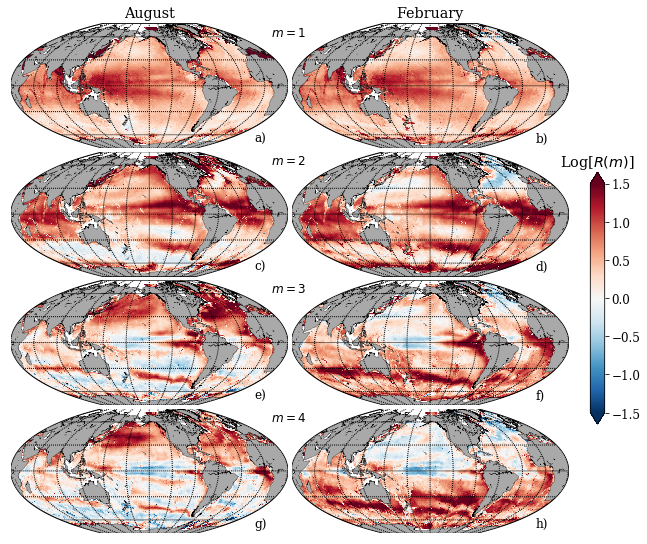

In [94]:
# several seasons, several modes

mods = [1,2,3,4] # must be power of 2
mths = [8,2]
proj = "mbtfpq" # hammer
lon0 = -150 # between -180 and 180
res = "l"
cmap = "RdBu_r"
field = "ratio"
vmin, vmax = -1.5, 1.5

labs = "abcdefghijkl"

nmd, nmt = len(mods), len(mths)
# These few lines circonvolve the interpolation problem when lon0 != 0
Nx = len(lon)
if lon0 != 0:
    ix0 = abs(lon-lon0).argmin()
    ixbnd = (ix0-Nx//2)%Nx
    ix = np.r_[np.arange(ixbnd,Nx), np.arange(ixbnd)]
else:
    ix = np.arange(Nx)

fig = plt.figure(figsize=(5*nmt,2.5*nmd))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nmd, nmt),
                     direction="row",
                     axes_pad=0.05,
                     add_all=True,
                     label_mode="1",
                     share_all=True,
                     )

print("loading and plotting", end=" ")
for imod,imth in product(range(nmd),range(nmt)):
    ax = grid[imod*nmt+imth]
    map = Basemap(projection=proj,llcrnrlat=lat.min(), urcrnrlat=lat.max(), 
                  lon_0=lon0, resolution=res, ax=ax)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='darkgrey',lake_color='white')
    map.drawmeridians(np.arange(0,360,30))
    map.drawparallels(np.arange(-90,90,30))

    ratio = load(mods[imod]-1,mths[imth],field)
    if imod*imth==0: xx, yy = map(*np.meshgrid(lon[ix], lat))
    # contour data over the map.
    cs = map.pcolormesh(xx, yy, np.log10(ratio[:,ix]), cmap=cmap, vmin=vmin, vmax=vmax)
    if imth==0:
        ax.text(.94, .9, r"$m="+str(imod+1)+"$", transform=ax.transAxes, fontsize=12)
    print(imod, imth, end=", ", flush=True)

ax = fig.add_axes([.93,.3,.02,.35])
hcb = plt.colorbar(cs, cax=ax, extend="both")
ax.set_title(r'Log[$R(m)$]')

for imt,mth in enumerate(mths):
    grid[imt].set_title(calendar.month_name[mth])
for ia,ax in enumerate(grid):
    ax.text(.88,.05,labs[ia]+")",transform=ax.transAxes)
    
if dosavefig:
    fig.savefig(dirpic+"GlobComp_LinAmpRatio.png", magnification="auto", 
                bbox_inches="tight", dpi=200)

In [95]:
fig.savefig(dirpic+"GlobComp_LinAmpRatio.png", magnification="auto", 
                bbox_inches="tight", dpi=200)

Text(0.5,1,'Winter')

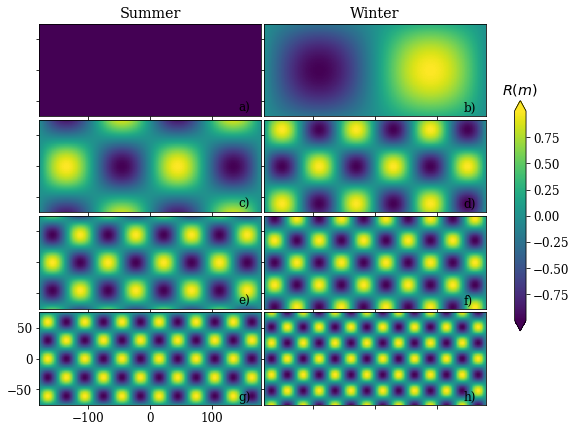

In [54]:

fig = plt.figure(figsize=(4*nmt,2*nmd))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nmd, nmt),
                     direction="row",
                     axes_pad=0.05,
                     add_all=True,
                     label_mode="1",
                     share_all=True,
                     )
for ia,ax in enumerate(grid):
    hpc = ax.pcolormesh(lon, lat, np.sin(ia*np.deg2rad(lon))[None,:]*np.cos(ia*np.deg2rad(lat))[:,None])
    ax.text(.9,.05,labs[ia]+")",transform=ax.transAxes)
    
ax = fig.add_axes([.95,.3,.02,.4], frame_on=True, )
hcb = plt.colorbar(hpc, cax=ax, extend="both")
ax.set_title(r'$R(m)$')

grid[0].set_title('Summer')
grid[1].set_title('Winter')

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


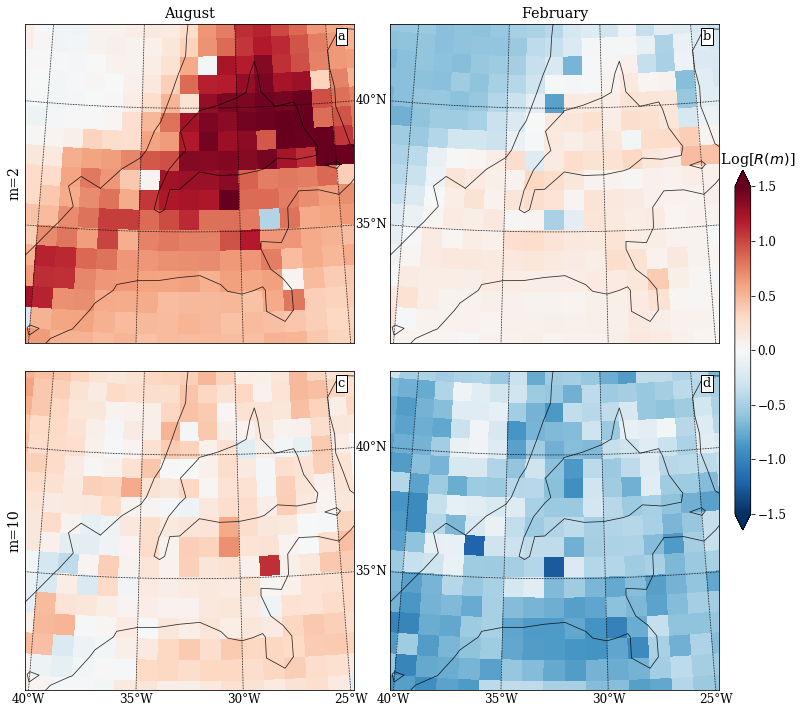

In [89]:
# Regional plot (for comparison with Lucky)
lonmin, lonmax = -41, -24
latmin, latmax = 30, 44
praj = "lcc"
cmap = "RdBu_r"
vmin, vmax = np.array([-1,1])*1.5
levs = np.linspace(vmin, vmax, 13)
strd = 5
grdcol = "grey"
zlevs=[0,2000,3500]
monts = [8,2]
modes = [2, 10] # actual moide number (not indices)

nc = Dataset(path_topo, "r") # NB: topo is present in data, i don't need to go back to this
topo = nc.variables['bathymetry'][ilat,:][:,ilon]
nc.close()

indx, = np.where((lon>=lonmin) & (lon<=lonmax))
indy, = np.where((lat>=latmin) & (lat<=latmax))
# pad indices
indx = np.pad(indx,1,"reflect",reflect_type="odd")
indy = np.pad(indy,1,"reflect",reflect_type="odd")
baby = topo[indy,:][:,indx]
lon0, lat0 = lon[indx].mean(), lat[indy].mean()
Lx = gsw.distance(np.array([[lonmin,lonmax]]),np.ones((1,2))*lat0)[0,0]*.98
Ly = gsw.distance(np.ones((1,2))*lon0, np.array([[latmin, latmax]]))[0,0]*.92

fig, axs = plt.subplots(len(modes), len(monts), figsize=(len(monts)*5+1,len(modes)*5))

for imod, isea in product(range(len(modes)),range(len(monts))):
    ax = axs[imod,isea]
    bm = Basemap(projection=praj,resolution=res,lon_0=lon0,
        lat_0=lat0,width=Lx,height=Ly, ax=ax)
    xx, yy = bm(*np.meshgrid(lon[indx], lat[indy]))
    bm.drawcoastlines(color='gray')
    bm.fillcontinents(color='gray')
    labx, laby = int(imod==len(modes)-1), int(isea==1)
    bm.drawparallels(np.arange(-60,70,strd),labels=[laby,0,0,0],linewidth=0.8,color="k")
    bm.drawmeridians(np.arange(-100,100,strd),labels=[0,0,0,labx],linewidth=0.8,color="k")
    hct = bm.contour(xx,yy,baby,levels=zlevs,colors="k",linewidths=0.8,alpha=0.8)
    for item in hct.collections:
        item.set_rasterized(True)
    ratio = load(modes[imod]-1,monts[isea],field="ratio")
    hpc = bm.pcolormesh(xx, yy, np.log10(ratio[indy,:][:,indx]), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.text(.95, .95, labs[imod*2+isea], transform=ax.transAxes, bbox=dict(facecolor="w",edgecolor="k", pad=2), fontsize=13)

for imo,mod in enumerate(modes):
    axs[imo,0].set_ylabel(r'm={}'.format(mod), fontsize=14)
for imt,mth in enumerate(monts):
    axs[0,imt].set_title(calendar.month_name[mth])
    
fig.tight_layout()

fig.subplots_adjust(right=0.9, wspace=.11)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
ac = plt.colorbar(hpc, cax=cbar_ax, extend="both")
ac.ax.set_title(r'       Log[$R(m)$]', ha="center")

if dosavefig:
    fig.savefig(dirpic+"GlobComp_LinAmpRat_Lucky.png", magnification="auto", 
                bbox_inches="tight", dpi=200)

In [86]:
np.pad(np.arange(5),1,"reflect",reflect_type="odd")

array([-1,  0,  1,  2,  3,  4,  5])

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


Text(0.85,0.85,'$m=3$')

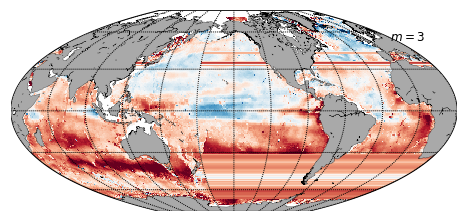

In [39]:
plt.figure(figsize=(8,5))
ax = plt.gca()
map = Basemap(projection='mbtfpq',llcrnrlat=lat.min(), urcrnrlat=lat.max(), 
              lon_0=-150, resolution='l')
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='darkgrey',lake_color='white')
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

xx, yy = map(*np.meshgrid(lon, lat))
# contour data over the map.
cs = map.pcolormesh(xx, yy, np.log10(ratio), cmap="RdBu_r", vmin=-1.5, vmax=1.5)
#ct = map.contour(xx, yy, topo, levels=[1000,2000,4000], color="gray", linewidths=.8)

ax.text(.85, .85, r"$m="+str(imod)+"$", transform=ax.transAxes, fontsize=12)

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater


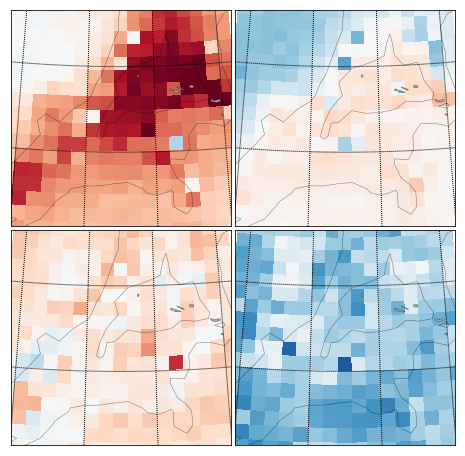

In [34]:
# plot on regional domain
# same as Fig 2 of paper
lonmin, lonmax = -41, -24
latmin, latmax = 30, 44
praj = "lcc"
cmap = "RdBu_r"
vmin, vmax = np.array([-1,1])*1.5
levs = np.linspace(vmin, vmax, 13)
monts = [8,2]
modes = [2, 10] # actual moide number (not indices)

indx, = np.where((lon>=lonmin) & (lon<=lonmax))
indy, = np.where((lat>=latmin) & (lat<=latmax))
baby = topo[indy,:][:,indx]
lon0, lat0 = lon[indx].mean(), lat[indy].mean()
Lx = gsw.distance(np.array([[lonmin,lonmax]]),np.ones((1,2))*lat0)[0,0]*.95
Ly = gsw.distance(np.ones((1,2))*lon0, np.array([[latmin, latmax]]))[0,0]*.9

fig = plt.figure(figsize=(10,8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 2),
                     direction="row",
                     axes_pad=0.05,
                     add_all=True,
                     label_mode="1",
                     share_all=True,
                     )

for imd, imt in product(range(len(modes)),range(len(monts))):
    ax = grid[imt+imd*len(monts)]
    map = Basemap(projection=praj, lon_0=lon0, lat_0=lat0, 
                  width=Lx, height=Ly, resolution="i", ax=ax)
    if (imd==0) & (imt==0):
        xx, yy = map(*np.meshgrid(lon[indx], lat[indy]))
        
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='darkgrey')
    map.drawmeridians(np.arange(0,360,5))
    map.drawparallels(np.arange(-90,90,5))
    ratio, _ = load(modes[imd]-1,monts[imt])
   
    hpc = map.contour(xx, yy, baby, levels=[0,2000,3500], colors="k", linewidths=0.5, alpha=0.5)
    for item in hpc.collections:
        item.set_rasterized(True)
    hpc = map.pcolormesh(xx, yy, np.log10(ratio[indy,:][:,indx]), cmap=cmap, vmin=vmin, vmax=vmax)

if dosavefig:
    fig.savefig(dirpic+"GlobComp_LinAmpRatio_Region.png", magnification="auto", bbox_inches="tight", dpi=200)

In [27]:
print(imt, imd)
print(modes[imd]-1,monts[imt])
ratio, _ = load(modes[imd]-1,monts[imt])
print(ratio.shape, lam.shape)

0 0
1 2
(19, 359) (227, 359)


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater


In [11]:
Lx

array([[ 1324156.32043806]])

## Old stuff

In [2]:
# load and plot single file

ipc = 0

path_data = KRYPTON+"DIAG/SeaSurf_ModAmp_ratio.{}.nc"

nc = Dataset(path_data.format(ipc), "r")
lon = nc.variables["lon"][:]
lat = nc.variables["lat"][:]
ilon = nc.variables['ilon'][:]
ilat = nc.variables['ilat'][:]
ratio= nc.variables['ratio'][:]
nc.close()

plon = np.pad(lon, (0,1), "reflect", reflect_type='odd')
plat = np.pad(lat, (0,1), "reflect", reflect_type='odd')

plt.figure()
plt.pcolormesh(plon, plat, np.log10(ratio[3,:,:]), cmap="RdBu_r", vmin=-1.5, vmax=1.5)
plt.colorbar(fraction=.02, extend="both")
#plt.contour(lon[indx], lat[indy], topo[indy,:][:,indx], levels=[1000, 2000, 3500], colors="grey", linewidths=.8)
plt.grid(True)
#plt.gca().set_aspect(1/np.sin(np.deg2rad(lat[indy].mean())))


FileNotFoundError: [Errno 2] No such file or directory: b'/data0/project/vortex/lahaye/DIAG/SeaSurf_ModAmp_ratio.0.nc'